In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import nnls
from scipy.sparse import diags
from scipy.linalg import svd
from sklearn.linear_model import LassoCV

In [19]:
col_names = ['Время', 'Амплитуда']

In [23]:
rb122 = pd.read_csv(r"C:\Users\Ольга\Downloads\NMR\РБ122.prn", header=None, sep='\s+', names = col_names)
i4529 = pd.read_csv(r"C:\Users\Ольга\Downloads\NMR\И4529.prn", header=None, sep='\s+', names = col_names)
i124  = pd.read_csv(r"C:\Users\Ольга\Downloads\NMR\И124.prn", header=None, sep='\s+', names = col_names)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Ольга\AppData\Local\Temp\ipykernel_27184\590936471.py:1: SyntaxWarning: invalid escape sequence '\s'
  rb122 = pd.read_csv(r"C:\Users\Ольга\Downloads\NMR\РБ122.prn", header=None, sep='\s+', names = col_names)
C:\Users\Ольга\AppData\Local\Temp\ipykernel_27184\590936471.py:2: SyntaxWarning: invalid escape sequence '\s'
  i4529 = pd.read_csv(r"C:\Users\Ольга\Downloads\NMR\И4529.prn", header=None, sep='\s+', names = col_names)
C:\Users\Ольга\AppData\Local\Temp\ipykernel_27184\590936471.py:3: SyntaxWarning: invalid escape sequence '\s'
  i124  = pd.read_csv(r"C:\Users\Ольга\Downloads\NMR\И124.prn", header=None, sep='\s+', names = col_names)


,Время,Амплитуда
0,0.5,1020.156466
1,1.0,1013.586268
2,1.5,1001.464677
3,2.0,999.287867
4,2.5,943.045233
...,...,...
29995,14998.0,-10.969489
29996,14998.5,4.657891
29997,14999.0,17.013071
29998,14999.5,-29.296794


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Ольга\AppData\Local\Temp\ipykernel_27184\4144577018.py:10: SyntaxWarning: invalid escape sequence '\s'
  header=None, sep='\s+', names=col_names)


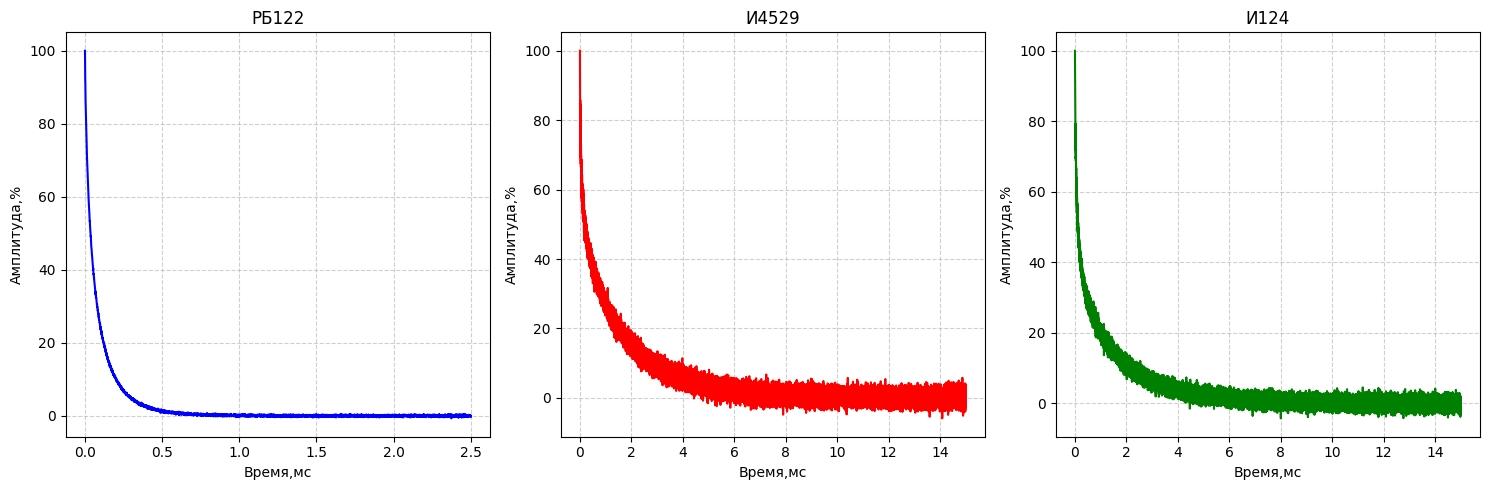

In [29]:
col_names = ['Время', 'Амплитуда']
files = ['РБ122.prn', 'И4529.prn', 'И124.prn']
colors = ['blue', 'red', 'green']
titles = ['РБ122', 'И4529', 'И124']

plt.figure(figsize=(15, 5))
for i, (file, color, title) in enumerate(zip(files, colors, titles), 1):
    data = pd.read_csv(f"C:\\Users\\Ольга\\Downloads\\NMR\\{file}", 
                       header=None, sep='\s+', names=col_names)
    data['Время'] = data['Время'] / 1000
    max_amp = data['Амплитуда'].max()
    data['Амплитуда'] = (data['Амплитуда'] / max_amp) * 100
    plt.subplot(1, 3, i)
    plt.plot(data['Время'], data['Амплитуда'], color=color)
    plt.title(title, fontsize=12)
    plt.xlabel('Время (мс)', fontsize=10)
    plt.ylabel('Амплитуда (%)', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Ольга\AppData\Local\Temp\ipykernel_27184\1537189234.py:2: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(f"C:\\Users\\Ольга\\Downloads\\NMR\\{file}", header=None, sep='\s+', names=['Время', 'Амплитуда'])
C:\Users\Ольга\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275.6222970414092, tolerance: 251.1608669089937
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ольга\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.4926135184651, tolerance: 241.4852820776568
  model = cd_fast.enet_coordinate_descent_gram(


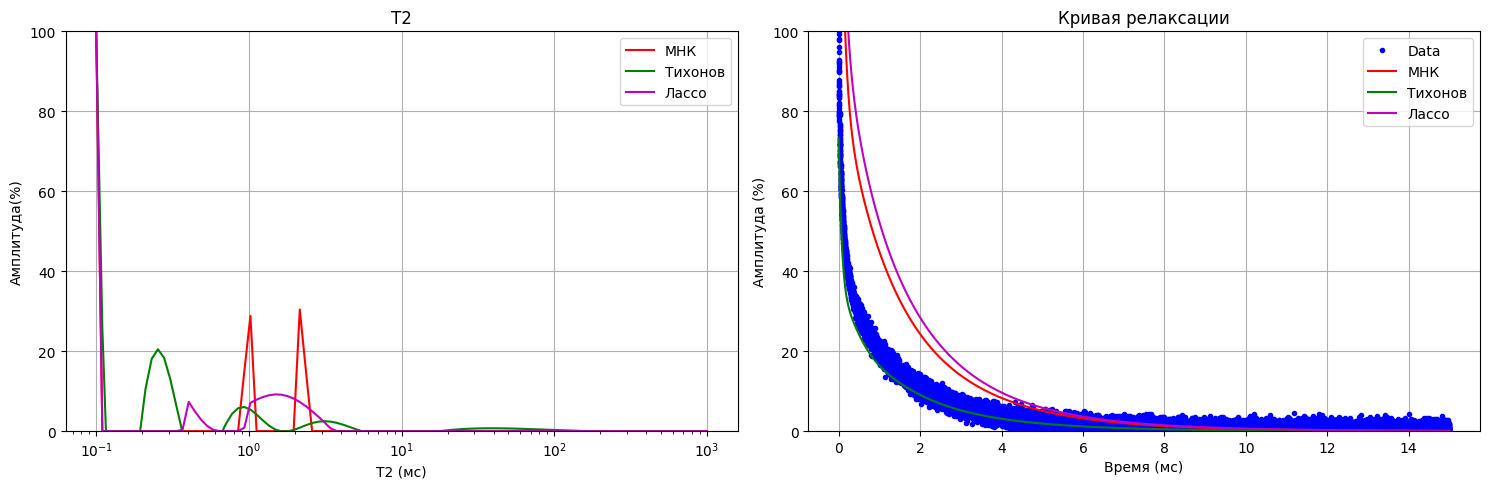

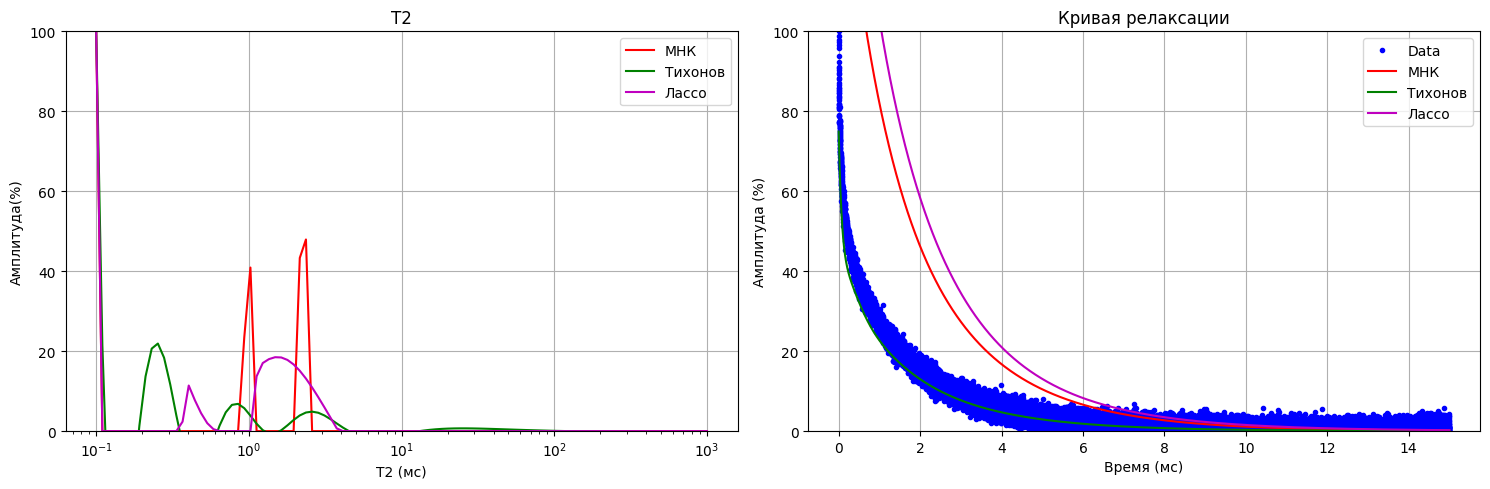

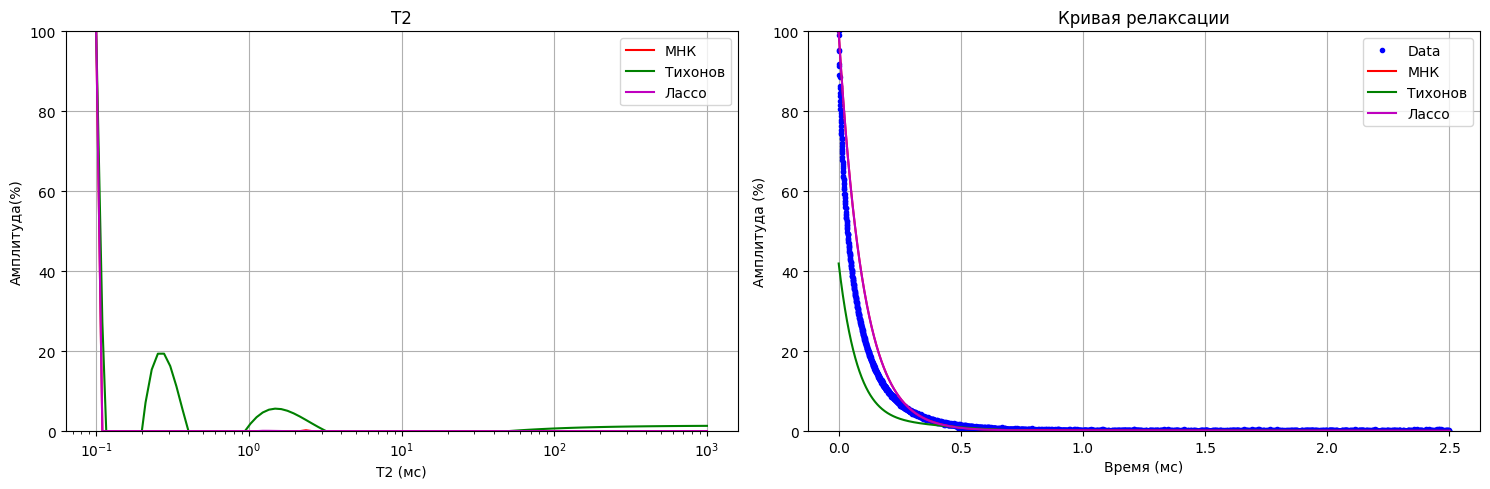

In [56]:
def load_data(file):
    data = pd.read_csv(f"C:\\Users\\Ольга\\Downloads\\NMR\\{file}", header=None, sep='\s+', names=['Время', 'Амплитуда'])
    data['Время'] /= 1000 
    data['Амплитуда'] = 100 * data['Амплитуда'] / data['Амплитуда'].max()
    return data

def create_kernel(times, t2_values):
    """Создание матрицы ядра"""
    return np.exp(-np.outer(times, 1/t2_values))

def analyze_nmr(file):
    data = load_data(file)
    times = data['Время'].values
    signal = data['Амплитуда'].values
    
    t2_grid = np.logspace(-1, 3, 100)
    K = create_kernel(times, t2_grid)
    
    # 1. Метод наименьших квадратов
    x_lsq, _ = nnls(K, signal)
    x_lsq = 100 * x_lsq / x_lsq.max()
    
    # 2. Тихоновская регуляризация
    U, s, Vh = svd(K, full_matrices=False)
    alpha = 0.1  # Фиксированный параметр для упрощения
    x_tik = Vh.T @ (U.T @ signal * s / (s**2 + alpha**2))
    x_tik = 100 * x_tik / x_tik.max()
    
    # 3. Lasso регуляризация
    model = LassoCV(alphas=[0.01, 0.1, 1], cv=3, max_iter=1000)
    model.fit(K, signal)
    x_lasso = 100 * model.coef_ / model.coef_.max()
    

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.semilogx(t2_grid, x_lsq, 'r-', label='МНК')
    plt.semilogx(t2_grid, x_tik, 'g-', label='Тихонов')
    plt.semilogx(t2_grid, x_lasso, 'm-', label='Лассо')
    plt.xlabel('T2 (мс)')
    plt.ylabel('Амплитуда(%)')
    plt.title('T2')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 100)  
    

    plt.subplot(1, 2, 2)
    plt.plot(times, signal, 'bo', ms=3, label='Data')
    plt.plot(times, K @ x_lsq, 'r-', label='МНК')
    plt.plot(times, K @ x_tik, 'g-', label='Тихонов')
    plt.plot(times, K @ x_lasso, 'm-', label='Лассо')
    plt.xlabel('Время (мс)')
    plt.ylabel('Амплитуда (%)')
    plt.title('Кривая релаксации')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 100) 
    
    plt.tight_layout()
    plt.show()

files = ['И124.prn', 'И4529.prn', 'РБ122.prn']
for file in files:
    analyze_nmr(file)